Visualizing Fisher's Iris data set.
See article: https://en.wikipedia.org/wiki/Iris_flower_data_set
This small dataset contains measurements from 3 species of Iris flower.
There are 50 observations of each species: Iris setosa, Iris virginica and Iris versicolor.
Here are a few lines from the data:
sepal_length,sepal_width,petal_length,petal_width,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa

We will look for correlations of the petal and sepal measurements with the species.
The goal is to find a classification algorithm.
Pandas has graphing functions that are commonly used for exploration of multi-variate datasets
that are typically given in a table.

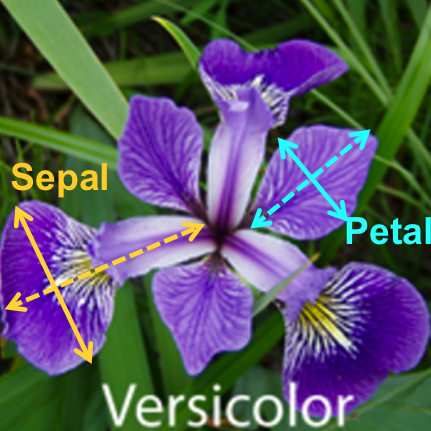

![title](iris_species.png)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# We want to use a unique color for each species. So we build a colormap based on the species list,
# and also build a list for each row in the dataset that specifies the color of each observation.
# This last list shouldn't be needed, but I was unable to get some of the color mapping options of
# the pandas graphs to work correctly.

def gen_colormap(df,column,palette=None):
    '''
    :param df: pandas dataframe (the input table)
    :param column: either the name of the species column or the column itself
    :param palette: a colormap. Default has 9 unique colors.
    :return: colormap (a dict with species-name as key) and colors (a value for each data row)
    '''
    if isinstance(column, basestring):
        factor_name = column #save off the name
        factor = df[column] #extract column
        classes = factor.unique()
        #df = df.drop(factor_name,axis=1) # remove from df, so it 
        # doesn't get a row and col in the plot.
    else:
        classes = column.unique()
        
    if palette is None:
        palette = ['#e41a1c', '#377eb8', '#4eae4b', 
                   '#994fa1', '#ff8101', '#fdfc33', 
                   '#a8572c', '#f482be', '#999999']

    if len(classes) > len(palette):
        raise ValueError('''Too many groups for the number of colors provided.
We only have {} colors in the palette, but you have {}
groups.'''.format(len(palette), len(classes)))

    color_map = dict(zip(classes,palette))
    # Apply color_map to the 'factor' column to generate list of colors for each data row
    colors = factor.apply(lambda group: color_map[group])
    return color_map,colors

In [11]:
# Read the data table
data = pd.read_csv('bezdekIris_copy.data')
# Create the colormap and color vector
my_cmap = ('red','blue','green')
my_colors,scatter_color = gen_colormap(data,'class',my_cmap)  
print 'species color map: '+str(my_colors) # it is a dict with species as key

species color map: {'Iris-virginica': 'green', 'Iris-setosa': 'red', 'Iris-versicolor': 'blue'}


There's a problem using the above color mapping with some of the pandas plotting methods.
Methods such as **parallel_coordinates** and **radviz** expect a colormap to be assigned as a list,
one value for each category (species). But the plots will be color coded not based on the
category name, but merely based on first unique occurrence.
So we have to build a color list in the order in which each species is first encountered in the
pandas dataframe. That is to say that a sorted dict would have been better (but I won't do that).

In [12]:
my_color_list = []
for c in scatter_color:
    if not c in my_color_list:
        my_color_list.append(c)
# It would be a mistake if there were more colors than species!
# The first color in the list will be the first species encountered in the dataset.
print 'my_color_list: '+str(my_color_list)

my_color_list: ['red', 'blue', 'green']


Use pandas graphing method **parallel_coordinates**
Draw lines for each row (each flower observation).
X-axis is paramater of column header: sepal and petal length and width.
Each distinct 'class' (last column of data) is assigned a unique color.
With this plot you can see which categories are useful discriminants of the 'class'.


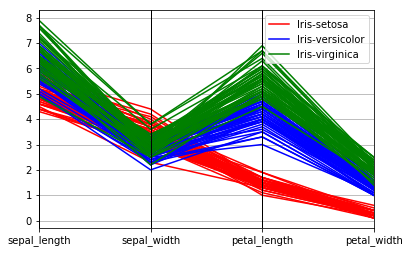

In [13]:
fig = plt.figure()
from pandas.plotting import parallel_coordinates
parallel_coordinates(data,'class', color=my_color_list)


It appears that petal_length and petal_width are useful discriminants, but sepal measurements are not.

Next is the **radviz** plot.
Plots a point for each observation.
The parameter categories are plotted on a unit circle.
There are 4 params in the iris dataset, so each "anchor" value is plotted at 90 degree angles.
That is, SepalLength=0, SepalWidth=90, PetalLength=180, PetalWidth=270.
Then a given flower observation will be plotted within this unit circle.
Each flower is plotted using a "spring tension minimization" algorithm.
Essentially each point is plotted so that distance from anchors is inversely proportional
to length or width value.


In [ ]:
from pandas.plotting import radviz
radviz(data,'class',color=my_color_list) 


In the radviz plot we can see that *Iris setosa* is readily distinguishable from the other two species,
but the radviz plot does not readily distinguish *Iris versicolor* from *Iris virginica*.

Next is a scatter plot matrix.
Each parameter is compared with the others.
There are 4 parameters, so this forms a 4x4 grid, but the grid is symmetrical (sort of)
along the diagonal. I.E., X vs Y in one cell, but Y vs X on the other side of the diagonal.


In [ ]:
from pandas.plotting import scatter_matrix

# diagonal: either kde or hist
# color-code by 'class' does not work with my pandas.
# Here is one solution: https://stackoverflow.com/questions/22943894/class-labels-in-pandas-scattermatrix
# That solution also plots color-coded curves along the diagonal - nice - I show that later.

# This is a default plot
scatter_matrix(data)


The default is not too helpful with this dataset, because we know there are three species and they have distinct value ranges.
We can instead plot a smooth curve (kde) in the diagonal cells and color code the scatter plots.
scatter_color is a list of color values corresponding to the species of each row in the data.

In [ ]:

scatter_matrix(data,marker='o',diagonal='kde',c=scatter_color)


Much better and scatter_matrix does this easily, provided you construct a color list for each sample.
But what about the curves in the diagonals? Can they be color coded? Of course, but what should we see?
The curves in the diagonal represent the distribution of the parameter, e.g., the petal_length values of all samples.

The improved version should show three curves in each, e.g., the petal_length of each species.
This gets complicated, because the work has to be done within matplotlib; pandas is too simple.

In [ ]:
# Here's one solution that requires scipy. Didn't look for other ways to do it.
# It plots smooth curves of the sample data within the diagonal cells of the scatter_matrix.
from scipy.stats import gaussian_kde    # generates kernel denisty estimation function using Gaussian kernel
import numpy as np
# do the scatter_matrix, but leave the diagonal plots empty
axarr = scatter_matrix(data,marker='o',c=scatter_color,diagonal=None)
# last data column is species, so don't use it.
for rc in xrange(len(data.columns)-1):
    for species in data['class'].unique():
        print 'processing rc=%d, species=%s, color=%s' %(rc,species,my_colors[species])
        y = data[data['class'] == species].iloc[:,rc]  # select only column data of one species
        gkde = gaussian_kde(y)   # generate function curve for this species
        ind = np.linspace(y.min(), y.max(), 1000)   # x-axis values
        axarr[rc][rc].plot(ind, gkde.evaluate(ind),c=my_colors[species])


These curves make sense: the curve is another view of the data in the scatter plots in the same column.
The width of each curve matches the width of the same color points in the scatter plots.
The max and min value of each curve tells us about the distribution, but I don't think you can correlate
the min-max values to the scatter plots in either the same column or row.

What else might we do here?
Certainly there are other kinds of plots that are useful for data exploration. Box charts are one.
The kinds of plots that are employed may depend on the data.

How about cleaning up the plots?
The size of the plots might be makde larger.
All the plots might be made to have the same size.
On the scatter_matrix the labels on the y-axis are too long. Have them drawn at an angle.
Make better use of alpha when plotting.
It's a shame that the plot types shown here can't easily use the same color-coding scheme. It would be nice if you could specify just two things for color coding: (1) a Series that contains the color selector and (2) a dict that maps selector to color. Why did I say "a Series that contains the color selector"? Because in many cases it will simply be a column from the data (as it is with the Iris dataset), but it could be a Series that is generated by combining some of the columns in the data.

Doing this data exploration is only the first step. The end goal is to create a classification algorithm for new samples.